<a href="https://colab.research.google.com/github/Ull22/wildtags/blob/main/wild_fasttext_vectors_with_top_koef_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyaspeller
from pyaspeller import YandexSpeller
speller = YandexSpeller()
import re
import pandas as pd
import numpy as np
from gensim.models.fasttext import FastText 
import gensim
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from numba import jit

In [ ]:
!gdown --id 116QQQur3ErFm1A-OZTitCgkJaMsaxPcf
qp = pd.read_csv('/content/query_popularity.csv')

Downloading...
From: https://drive.google.com/uc?id=116QQQur3ErFm1A-OZTitCgkJaMsaxPcf
To: /content/query_popularity.csv
100% 14.2M/14.2M [00:00<00:00, 223MB/s]


Популярность запросов — относительная популярность запросов за тот же период, что и в файле с Историей Поиска.  
- **query** - текст запроса
- **query_popularity** - относительная популярность запроса за взятый период. 1 наименее популярный, 10 — наиболее

In [ ]:
qp.head(10)

,query,query_popularity
0,ноутбук,10
1,куртка женская осенняя,10
2,ботинки женские,10
3,видеокарта,10
4,пальто женское осеннее,10
5,пальто женское,10
6,джинсы женские,10
7,кроссовки мужские,10
8,кроссовки женские,10
9,куртка мужская,10


In [ ]:
qp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336988 entries, 0 to 336987
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   query             336987 non-null  object
 1   query_popularity  336988 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.1+ MB


In [ ]:
qp.isna().sum()

query               1
query_popularity    0
dtype: int64

In [ ]:
qp[qp['query'].isna()]

,query,query_popularity
5823,NaN,10


In [ ]:
qp.dropna(inplace=True)

In [ ]:
qp['query_popularity'].value_counts()

2     33820
4     33771
6     33748
1     33733
5     33729
8     33711
10    33699
9     33691
7     33686
3     33399
Name: query_popularity, dtype: int64

In [ ]:
#все запросы уникальные
len(qp['query'].unique())

336987

In [ ]:
#длина запросов в символах(мин, макс, среднее, медиана)
uq_tostr = qp['query'].str
sym_sent = uq_tostr.len()
sym_sent.min(), sym_sent.max(), sym_sent.mean(), sym_sent.median()

(1, 200, 22.00808043040236, 20.0)

In [ ]:
#длина слов в словах(мин, макс, среднее, медиана)
word_sent = qp['query'].apply(lambda x: len(str(x).split()))
word_sent.min(), word_sent.max(), word_sent.mean(), word_sent.median()

(1, 35, 3.2997088908474215, 3.0)

- среднее количество символов в запросе 22, медиана 20. минимально 1 буква, максимальное 200 символов.
- среднее и медианное количество слов 3.  Минимально 1 слово в запросе, максимльно 35.

## Работа с текстом

In [ ]:
qp = qp[~qp['query'].str.len() <= 2]

- удаляем 1 и 2 буквенные значения 
- исключение могло быть а4, а3, аа (не реализовано!)

In [ ]:
qp = qp[qp['query'].str.len() <= 30]

- удаляем запросы свыше 31 символа(с запасом, так как среднее было 22); 

In [ ]:
word_sent = qp['query'].apply(lambda x: len(str(x).split()))
qp = qp[word_sent <=3]

- удаляем запросы более 3 слов(это среднее-медианное значение), да и на wildberries поиске при более 3 слов, поиск подсказки на работают.

In [ ]:
# qp['query'] = qp['query'].apply(lambda x: x.replace(r'[\s\W]', '') if len(x) == 3 else x)
# #qp.loc[336411]

# qp[qp['query'].str.len() == 3].tail(50)
# #qp[qp['query'].str.len() == 3]['query'].str.replace(r'[\s\W]', '')
# # qp.loc[del3]

qp = qp[~qp['query'].str.len() <= 2]

- здесь по хорошему хотелось в 3-х символьных запросах, удалить запросы с пробелом, только все цифры или только все символы;  
!не хватилов времени и просто были удалены все 3-х символьные запросы)

In [ ]:
qp = qp[qp['query_popularity']>1]

- удаляем непопулярные запросы в рейтингом 1;

In [ ]:
# функция для создания словаря транслитераций
def make_trans():
    a = 'a b c d e f g h i j k l m n o p q r s t u v w x y z ё'.split()
    b = 'а б с д е ф г х и ж к л м н о п к р с т у в в х у з е'.split()
    trans_dict = dict(zip(a, b))
    trans_table = ''.join(a).maketrans(trans_dict)
    return trans_table
trans_table = make_trans()

- функция для транслитерации входящих запросов

In [ ]:
def textcleaner(text):
  text = text.str.lower()
  text = text.str.strip()
  # try:  
  #     text = speller.spelled(text)
  # except:
  #     text = text
  text = text.str.replace(fr"((?:\d+p)?\d+)\s*({'мг|г|гр|кг|мл|л|шт|мм|см|м'})\b", r" \1\2 ") #"21 кг" -> "21кг"
  text = text.str.replace(r'(\d+)[\,](\d+)', r' \1.\2 ') #2,5 на 2.5
  return text

Функция:
- переводит запросы в нижний регистр;
- удаляем пробелы в начале и в конце предложения;
- применяем YandexSpeller для исправления ошибок, в коде отключен так как работа длится около 13часов;
- слияние единиц измерения с цифрами "21 кг" -> "21кг";
- изменение с запятой на точку в float 2,5 на 2.5;

In [ ]:
%%time
#qp['query_new'] = qp['query'].apply(textcleaner) # вариант для запуска с 13ч YandexSpeller
qp['query_new'] = textcleaner(qp['query']) #без YandexSpeller

CPU times: user 1.36 s, sys: 14.1 ms, total: 1.37 s
Wall time: 1.36 s


In [ ]:
qp = qp[~qp['query_new'].map(lambda x: x.isascii())]

- удаление всех прочих символов, смайлов и т.д

In [ ]:
qp['query_new'] = qp['query_new'].drop_duplicates()
qp.dropna(inplace=True)

- удаление дупликатов;

In [ ]:
##!не забыть автоматизировать
qp = qp.loc[qp[qp['query'] != 'զգեստներ'].index]

- вылез запрос на армянском языке, удаление вручную. По хорошему необходимо автоматизировать, определять какой язык в ячейке и переводить

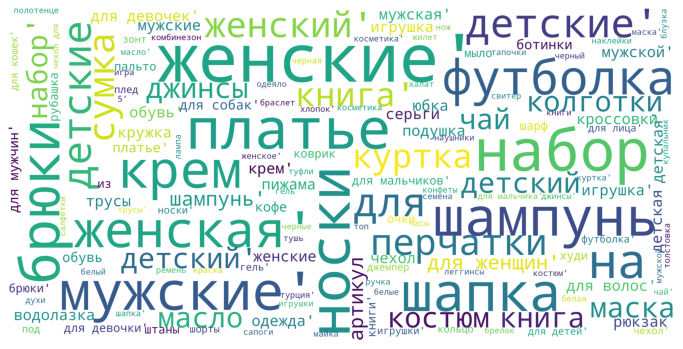

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=10,
        #random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(qp['query_new'].to_list())

- топовые запросы, из частого это слова и словосочетания женский - мужской - детский

In [ ]:
!gdown --id 1-00TMIarmArilwhAE3QUeOokyK7lMdqX
qp1 = pd.read_csv('/content/qp.csv', index_col='Unnamed: 0')

- новая загрузка csv файла, qp.csv - это файл обработанный операциями с текстом приведенными выше и  YandexSpeller. 

In [ ]:
qp1['query_train'] = qp1['query_new'].str.split()

- создаём столбец для обучения, делим  на слова

In [ ]:
qp1['query_train'].head(3)

0                     [ноутбук]
1    [куртка, женская, осенняя]
2            [ботинки, женские]
Name: query_train, dtype: object

In [ ]:
qp1.shape

(154343, 4)

- наш датасет сократился в 2 раза с 336т до 154т

In [ ]:
#qp1.to_csv('/content/drive/MyDrive/wild/qp1.csv')

## Векторизация

In [ ]:
%%time
model = FastText(qp1['query_train'], size=200, window=5, min_count=5, iter=500, sg=1, min_n=2, max_n=7)

CPU times: user 23min 17s, sys: 6.52 s, total: 23min 23s
Wall time: 8min 36s


- переводим в векторы с помощью fasttext

In [ ]:
%%time
model.wv.similar_by_word('ноут')

CPU times: user 62.8 ms, sys: 27.1 ms, total: 89.9 ms
Wall time: 81.2 ms


[('ноутбук', 0.9010567665100098),
 ('ноутбука', 0.8627800941467285),
 ('компьютер', 0.661837637424469),
 ('компьютера', 0.6264170408248901),
 ('компьютерный', 0.577043890953064),
 ('macbook', 0.5769342184066772),
 ('компьютерная', 0.5695112943649292),
 ('компьютерное', 0.565842866897583),
 ('роутер', 0.5520210266113281),
 ('клавиатуру', 0.5510116219520569)]

- проверяем на сходимость

In [ ]:
#сохранение модели на сервер
#model.save('/content/drive/MyDrive/wild/fasttext.model')

In [ ]:
qp1['query_new'][qp1['query_new'].str.contains('ноут')].head(10)

0                    ноутбук
268          ноутбук игровой
392               ноутбук hp
545     ноутбук 14s-fq0072ur
652          игровой ноутбук
694             игровой ноут
980             ноутбук asus
1191      сумка для ноутбука
1197                ноутбуки
1296            ноутбуки msi
Name: query_new, dtype: object

In [ ]:
def word_averaging(wv, words):
    mean = np.zeros((wv.vector_size,))
    
    for word in words:
      try:
        mean += wv.get_vector(word)
      except:
        mean += np.zeros((wv.vector_size,))

    mean = gensim.matutils.unitvec(mean)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list])

- функция переводит слова в вектора, а для запросов состояющих из более 1 слова усредняет вектора

In [ ]:
train_data = qp1['query_train'].apply(lambda x: [i for i in x if len(i) > 1])
X_wv = word_averaging_list(model.wv, train_data)
#np.save('/content/drive/MyDrive/wild/X_wv.npy', X_wv) #для выгрузки на сервер

- здесь в X_wv векторные значения наших запросов длиною 200

## Предикт

- Идея предикта, заключается: 
1. пустая строка или 1 буква:
- если еще нет никакого символа в поисковой строке, то выводиться топ 10 запросов;
- если 1 буква, то топ 10 запросов, начинающихся на эту букву;
2. 2 буквы и более(без ошибок):
- преобразование слова или букв из запроса в вектор, получаемые из fasttext;
- нахождение наименьшего косинусного расстояния между текущим запросом и базой векторов;
- вывод топ 100 по убыванию;
- из топ 100 сортируем по популярности запросов + применяем регулярные выражения, чтобы получить запросы состоющие из букв в начале первого или второго слова;
- из всего этого сокращаем до топ 10.
3. 3 буквы и более(с ошибками):
- преобразование слова или букв из запроса в вектор, получаемые из fasttext;
- нахождение наименьшего косинусного расстояния между текущим запросом и базой векторов;
- вывод топ 10 по убыванию, самые близкие к нужному слову без ошибки;
- сортировка их по популярности запроса.

In [ ]:
@jit(nopython=True)
def cosine_similarity_numba(u, v):
    cos = []
    for j in range(u.shape[0]):
      assert(u[j].shape[0] == v[j].shape[0])
      uv = 0
      uu = 0
      vv = 0
      for i in range(u[j].shape[0]):
          uv += u[j][i]*v[j][i]
          uu += u[j][i]*u[j][i]
          vv += v[j][i]*v[j][i]
      cos_theta = 0
      if uu!=0 and vv!=0:
          cos_theta = uv/np.sqrt(uu*vv)
      cos.append(cos_theta)
    return cos

- расчет косинусного расстояния для 154т векторов долгое занятия, пришлось ускоряться с помощью numba, говорят она быстре си++ ) 

In [ ]:
#топ рекомендаций без нажатия клавиши и только с 1 символом
def q_rec_top(n, symbol=''):
  q_pop = qp.sort_values('query_popularity', ascending=False)['query']
  if n == 0:
    top10_without_sym = q_pop[:10].to_list()
    return top10_without_sym
  if n == 1:
    top10_with_1_sym = q_pop[q_pop.str.find(symbol) == 0][:10].tolist()
    return top10_with_1_sym

In [ ]:
## предикт функция
def sBar(tags=10):
  text = input().lower()
  text = text.translate(trans_table)
  if len(text) <=1:
    top_ten = q_rec_top(len(text), text)
  else:
    pred_vect = model.wv[text]
    pred_t = np.expand_dims(pred_vect, axis=0)
    k = np.repeat(pred_t, X_wv.shape[0], axis=0)
    k = k.astype('float64')
    score = cosine_similarity_numba(X_wv,k)
    ind_pred_10 = np.argsort(score)[-10:][::-1]
    ind_pred_100 = np.argsort(score)[-100:][::-1]
    top_10 = qp1.iloc[ind_pred_10].sort_values('query_popularity', ascending=False)
    top_100 = qp1.iloc[ind_pred_100].sort_values('query_popularity', ascending=False)
    ten_1=top_100[top_100['query_new'].str.contains(fr"^{text}")]['query_new'][:10]
    ten_2 = pd.Series([0])
    top_ten = ten_1.to_list()
    if len(ten_1) < 10:
      ten_2 = top_100[~top_100['query_new'].str.contains(fr"^{text}") & top_100['query_new'].str.contains(fr"{text}")]['query_new'][:(10 -len(ten_1))]
      top_ten = ten_1.to_list() + ten_2.to_list()
  return top_ten if top_ten else top_10['query_new'][:10].to_list()

In [ ]:
%%time
sBar()

р
CPU times: user 166 ms, sys: 1.01 ms, total: 167 ms
Wall time: 1.83 s


['рулонная штора DECOFEST',
 'рыболовный костюм',
 'ремень серебристый женский',
 'рубанок электрический',
 'рубашка жакет',
 'руны серебро',
 'райзер для видеокарты',
 'роликовые кроссовки',
 'рюкзак спортивный женский',
 'рубашка женская zolla']

Теперь о том, что не сделано:
- исправление раскладки клавиатуры;
- определять иностранные языки и переводить, или выводить поисковую подсказку на этих языках;
- работа с 2 и 3 символьными запросами, например А4, АА, AAA и т.д., на текущий момент все 2-3 символьные запросы удалены;
- юзеры, их история запросов, - выводить в поиск как топовые из истории, так и новые из топовые из популярных запросов.
- рекомендации одежды по сезону;
- предложение в запросе как товаров разовой покупки, так и повседневных; 
